In [44]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from dateutil.parser import parse
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

In [45]:
# opening the zarr_dataset
os.environ["L5KIT_DATA_FOLDER"] = "../../../prediction-dataset/"
#os.environ["L5KIT_DATA_FOLDER"] = "../prediction-sample-dataset/"
cfg = load_config_data("./visualisation_config.yaml")
dm = LocalDataManager()
dataset_path = dm.require(cfg["val_data_loader"]["key"])
zarr_dataset = ChunkedDataset(dataset_path)
zarr_dataset.open()

# using EgoDataset interface to extract AV data
rast = build_rasterizer(cfg, dm)
ego_dataset = EgoDataset(cfg, zarr_dataset, rast)
print(ego_dataset)
# agent_dataset = AgentDataset(cfg, zarr_dataset, rast)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   24838    |  1893736   |     316008    |       0.69      |        248.38        |        76.24         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [4]:
# printing the frame ranges that make up each scene
scene_frame_indexes = np.array([[0,0]])
for i in range(len(zarr_dataset.scenes)):
    scene_frame_indexes = np.append(scene_frame_indexes, [[zarr_dataset.scenes[i][0][0], zarr_dataset.scenes[i][0][1]]], axis = 0)
    
scene_frame_indexes = np.delete(scene_frame_indexes, 0, 0)
print(scene_frame_indexes)

[[    0   248]
 [  248   497]
 [  497   746]
 [  746   995]
 [  995  1244]
 [ 1244  1493]
 [ 1493  1742]
 [ 1742  1991]
 [ 1991  2240]
 [ 2240  2489]
 [ 2489  2738]
 [ 2738  2987]
 [ 2987  3236]
 [ 3236  3485]
 [ 3485  3734]
 [ 3734  3983]
 [ 3983  4232]
 [ 4232  4481]
 [ 4481  4730]
 [ 4730  4979]
 [ 4979  5228]
 [ 5228  5477]
 [ 5477  5725]
 [ 5725  5973]
 [ 5973  6221]
 [ 6221  6469]
 [ 6469  6717]
 [ 6717  6965]
 [ 6965  7213]
 [ 7213  7461]
 [ 7461  7709]
 [ 7709  7957]
 [ 7957  8205]
 [ 8205  8453]
 [ 8453  8701]
 [ 8701  8949]
 [ 8949  9197]
 [ 9197  9445]
 [ 9445  9693]
 [ 9693  9941]
 [ 9941 10189]
 [10189 10437]
 [10437 10685]
 [10685 10933]
 [10933 11182]
 [11182 11431]
 [11431 11680]
 [11680 11929]
 [11929 12177]
 [12177 12425]
 [12425 12673]
 [12673 12921]
 [12921 13169]
 [13169 13417]
 [13417 13665]
 [13665 13913]
 [13913 14161]
 [14161 14409]
 [14409 14657]
 [14657 14905]
 [14905 15153]
 [15153 15401]
 [15401 15649]
 [15649 15897]
 [15897 16145]
 [16145 16393]
 [16393 16

In [18]:
dataset = EgoDataset(cfg, zarr_dataset, rast)
position_AV = np.empty((len(dataset), 5), dtype=np.float32)
output = np.empty((len(dataset), 2), dtype=np.float32)
for i, data in enumerate(dataset):
    position_AV[i] = [data["centroid"][0], data["centroid"][1], data["yaw"], data["target_velocities"][0][0], data["target_velocities"][0][1]]
    output[i] = [data["target_positions"][0][0], data["target_positions"][0][1]]



In [36]:

inputs = torch.from_numpy(position_AV)
outputs = torch.from_numpy(output)
inputs = inputs.to(device)
outputs = outputs.to(device)

In [37]:
dataset = TensorDataset(inputs, outputs)
val_percent = 0.2
num_rows = len(inputs)
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [38]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_ds, batch_size, num_workers = 0)

In [39]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            #nn.Linear(input_size, 2)
            nn.Linear(5, 32),
            nn.ReLU(),
            nn.Linear(32,64),
            nn.ReLU(),
            nn.Linear(64,2)
        )
        
    def forward(self, xb):
        out = self.layers(xb)                       
        return out
    
    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [40]:
model = NeuralNetwork()
model.to(device)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=5, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [41]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [42]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 25.16364288330078}


In [43]:
epochs = 10000
lr = 1e-6
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 0.5439
Epoch [40], val_loss: 0.2838
Epoch [60], val_loss: 0.2035
Epoch [80], val_loss: 0.1830
Epoch [100], val_loss: 0.1763
Epoch [120], val_loss: 0.1672
Epoch [140], val_loss: 0.1421
Epoch [160], val_loss: 0.1497
Epoch [180], val_loss: 0.1504
Epoch [200], val_loss: 0.1384
Epoch [220], val_loss: 0.1179
Epoch [240], val_loss: 0.1088
Epoch [260], val_loss: 0.1103
Epoch [280], val_loss: 0.1052
Epoch [300], val_loss: 0.1124


KeyboardInterrupt: 

In [15]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach()
    return target, prediction

In [16]:
targets = []
predictions = []
for i in range(len(val_ds)):
    input, target = val_ds[i]
    target, prediction = predict_single(input, target, model)
    targets.append(target)
    predictions.append(prediction)

xtargets = []
ytargets = []
xpredictions = []
ypredictions = []
for i in range(len(targets)):
    xtargets.append(targets[i][0])
    ytargets.append(targets[i][1])
    xpredictions.append(predictions[i][0])
    ypredictions.append(predictions[i][1])


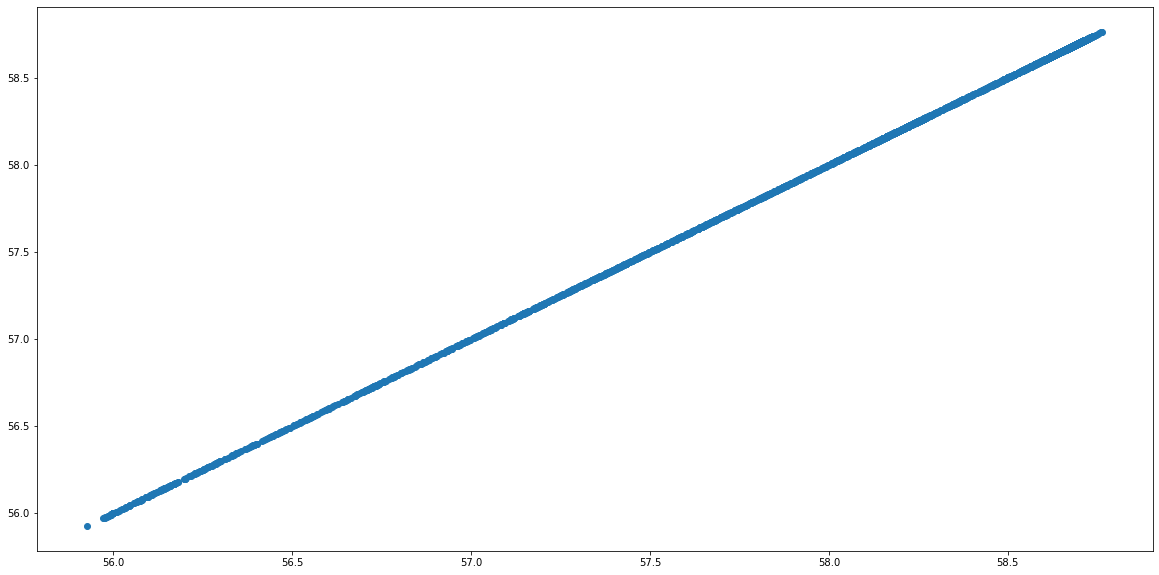

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(xtargets, ytargets)


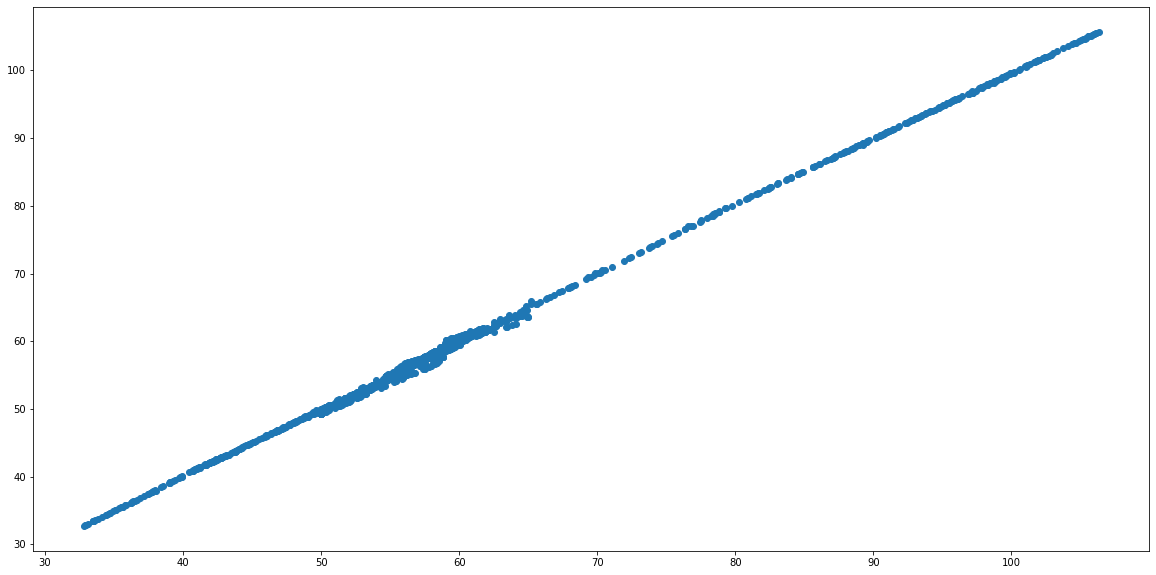

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(xpredictions, ypredictions)